#Task

Visualize 3 types of dataset shift for linear regression task with 1d or 2d dataset. For each type of dataset shift plot the RMSE dependency on the dataset shift.

# Solution


A regression problem is defined by:
1. A set of features $x$.
2. A target variable $y$.
3. A joint distribution $P(y, x)$.

We consider two types of problems:
1. $X → Y$ problems, where the target is causally determined by the values of features.
2. $Y → X$ problems, where the target causally determines the values of features.

The joint distribution $P(y, x)$ can be written as
1. $P(y|x)P(x)$ in $X → Y$ problems
2. $P(x|y)P(y)$ in $Y → X$ problems

**Dataset shift** appears when training and test joint distributions are different.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import norm

%matplotlib inline

## Covariate shift

Covariate shift appears only in $X → Y$ problems, and is defined as the case where $P_{\text{train}}(y|x) = P_{\text{test}}(y|x)$ and $P_{\text{train}}(x) \neq P_{\text{test}}(x)$.

We will consider the following task:
1. $P_{\text{train}}(x) = \mathcal{N}(0, 1)$
2. Test data distribution is Gaussian mixture
3. $P_{\text{train}}(y|x) = P_{\text{test}}(y|x) = \mathcal{N}(w \cdot x + b, \sigma^2)$

In [2]:
def generate_target(x, weight, bias, std=0.07):
  noise = np.random.normal(0, std, len(x))
  y = x*weight + bias + noise 
  return y

def sample_from_mixture(mean1, mean2, std, size):
  x1 = np.random.normal(mean1, std, size)
  x2 = np.random.normal(mean2, std, size)
  choice = np.random.rand(size)
  return np.where(choice < 0.5, x1, x2)

In [3]:
N = 50
scale = 1
weight = 0.1
bias = 1

train_x = np.random.normal(0, scale, N)
train_y = generate_target(train_x, weight, bias)

test_x = sample_from_mixture(-2, 2, scale, N)
test_y = generate_target(test_x, weight, bias)

model = LinearRegression()
model.fit(train_x.reshape(-1, 1), train_y)

LinearRegression()

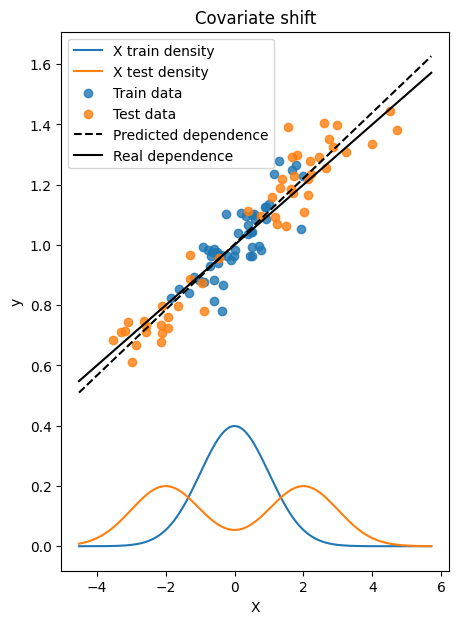

In [4]:
plt.figure(figsize=(5, 7))
grid = np.linspace(min(test_x.min(), train_x.min()) - 1, max(test_x.max(), train_x.max()) + 1, 1000)
train_pdf = norm(loc=0, scale=scale).pdf(grid)
test_pdf = (norm(loc=-2, scale=scale).pdf(grid) + norm(loc=2, scale=scale).pdf(grid))/2

plt.plot(grid, train_pdf, label='X train density')
plt.plot(grid, test_pdf, label='X test density')
plt.scatter(train_x, train_y, alpha=0.8, label='Train data')
plt.scatter(test_x, test_y, alpha=0.8, label='Test data')
plt.plot(grid, model.predict(grid.reshape(-1, 1)), label='Predicted dependence', c='black', linestyle='--')
plt.plot(grid, grid*weight + bias, label='Real dependence', c='black')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.title('Covariate shift');

In [7]:
shift_values = np.linspace(0, 20, 100)
scores = []
for shift in shift_values:
  test_x = sample_from_mixture(-shift, shift, scale, N)
  test_y = generate_target(test_x, weight, bias)
  preds = model.predict(test_x.reshape(-1, 1))
  rmse = np.sqrt(np.mean((test_y - preds)**2))
  scores.append(rmse)

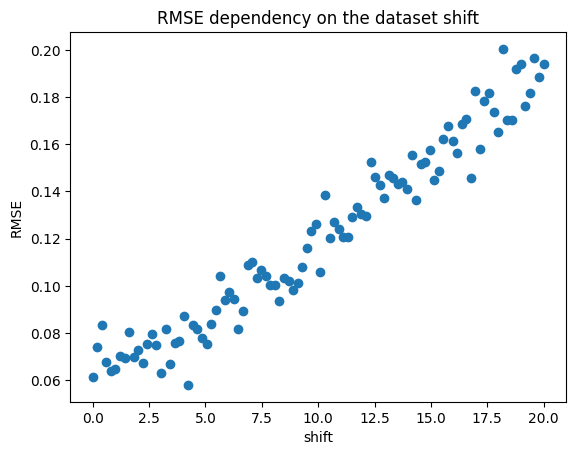

In [8]:
plt.scatter(shift_values, scores)
plt.ylabel('RMSE')
plt.xlabel('shift')
plt.title('RMSE dependency on the dataset shift');

## Prior probability shift

Prior probability shift appears only in $Y → X$ problems, and is defined as the case where $P_{\text{train}}(x|y) = P_{\text{test}}(x|y)$ and $P_{\text{train}}(y) \neq P_{\text{test}}(y)$.

We will consider the following task:
1. $P_{\text{train}}(y) = \mathcal{N}(0, 1)$
2. $P_{\text{test}}(y) = \mathcal{N}(shift, 1)$
3. $P_{\text{train}}(x|y) = P_{\text{test}}(x|y) = \mathcal{N}(w \cdot y + b, \sigma^2)$

In [9]:
N = 50
scale = 1
weight = 0.1
bias = 1

train_y = np.random.normal(0, scale, N)
train_x = generate_target(train_y, weight, bias)

test_y = np.random.normal(2, scale, N)
test_x = generate_target(test_y, weight, bias)

model = LinearRegression()
model.fit(train_x.reshape(-1, 1), train_y)

LinearRegression()

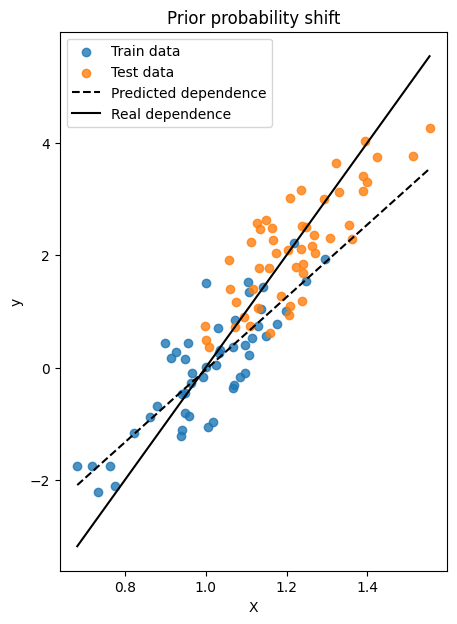

In [10]:
plt.figure(figsize=(5, 7))
grid = np.linspace(min(test_x.min(), train_x.min()), max(test_x.max(), train_x.max()), 1000)

plt.scatter(train_x, train_y, alpha=0.8, label='Train data')
plt.scatter(test_x, test_y, alpha=0.8, label='Test data')
plt.plot(grid, model.predict(grid.reshape(-1, 1)), label='Predicted dependence', c='black', linestyle='--')
plt.plot(grid, (grid - bias)/weight, label='Real dependence', c='black')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.title('Prior probability shift');

In [12]:
shift_values = np.linspace(0, 10, 100)
scores = []
for shift in shift_values:
  test_y = np.random.normal(shift, scale, N)
  test_x = generate_target(test_y, weight, bias)
  preds = model.predict(test_x.reshape(-1, 1))
  rmse = np.sqrt(np.mean((test_y - preds)**2))
  scores.append(rmse)

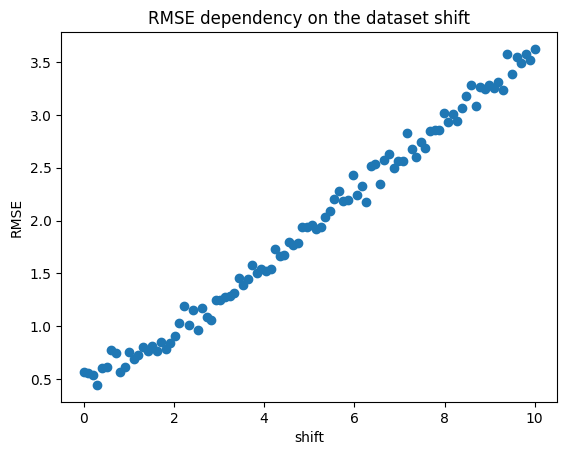

In [13]:
plt.scatter(shift_values, scores)
plt.ylabel('RMSE')
plt.xlabel('shift')
plt.title('RMSE dependency on the dataset shift');

## Concept shift

In $X → Y$ problems, concept shift is defined as the case where $P_{\text{train}}(y|x) \neq P_{\text{test}}(y|x)$ and $P_{\text{train}}(x) = P_{\text{test}}(x)$.

We will consider the following task:
1. $P_{\text{train}}(x) = P_{\text{test}}(x) = \mathcal{N}(0, 1)$
2. $P_{\text{train}}(y|x) = \mathcal{N}(w \cdot y + b, \sigma^2)$
3. $P_{\text{test}}(y|x) = \mathcal{N}(w' \cdot y + b, \sigma^2)$

In [29]:
N = 50
scale = 1
weight = 0.1
bias = 1

train_x = np.random.normal(0, scale, N)
train_y = generate_target(train_x, weight, bias)

test_x = np.random.normal(0, scale, N)
test_y = generate_target(test_x, weight + 0.1, bias)

model = LinearRegression()
model.fit(train_x.reshape(-1, 1), train_y)

LinearRegression()

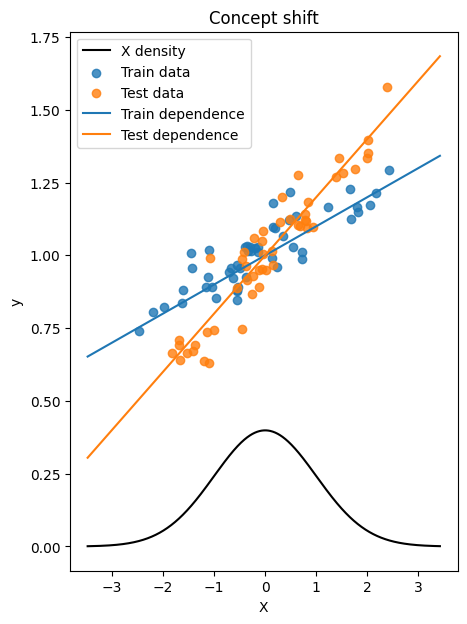

In [30]:
plt.figure(figsize=(5, 7))
grid = np.linspace(min(test_x.min(), train_x.min()) - 1, max(test_x.max(), train_x.max()) + 1, 1000)
pdf = norm(loc=0, scale=scale).pdf(grid)

plt.plot(grid, pdf, label='X density', c='black')
plt.scatter(train_x, train_y, alpha=0.8, label='Train data')
plt.scatter(test_x, test_y, alpha=0.8, label='Test data')
plt.plot(grid, grid*weight + bias, label='Train dependence')
plt.plot(grid, grid*(weight + 0.1) + bias, label='Test dependence')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.title('Concept shift');

In [31]:
shift_values = np.linspace(0, 1, 100)
scores = []
for shift in shift_values:
  test_y = generate_target(test_x, weight + shift, bias)
  preds = model.predict(test_x.reshape(-1, 1))
  rmse = np.sqrt(np.mean((test_y - preds)**2))
  scores.append(rmse)

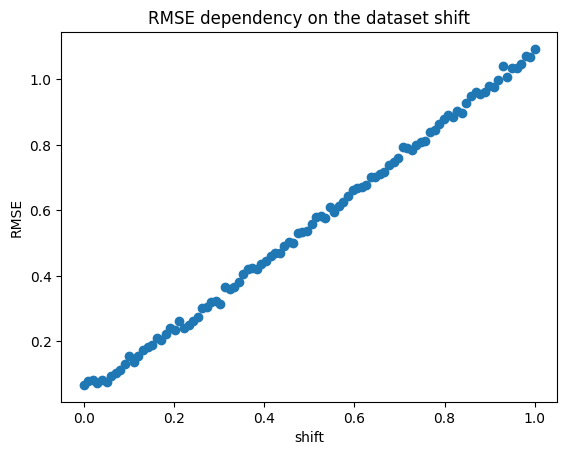

In [32]:
plt.scatter(shift_values, scores)
plt.ylabel('RMSE')
plt.xlabel('shift')
plt.title('RMSE dependency on the dataset shift');

Conclusion:

Experiments show that RMSE grows with the increase in the dataset shift